In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors
np.set_printoptions(precision=3, suppress=True)

from wordcloud import WordCloud, STOPWORDS

import urllib.request
from PIL import Image
import re 
import seaborn as sns

import plotly.express as px
import plotly.io as pio
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
import folium
from folium.plugins import HeatMap

import ipywidgets as widgets
from ipywidgets import Layout, Label, HBox, VBox, HTML
from IPython.display import display, clear_output
import IPython

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 75

## Nhập dữ liệu

In [3]:
# Tên các sheet trong file saved_file.xlsx
name_sheet = ["ID","DATA","RATING"]

In [4]:
data_ID = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[0])
data_DATA = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[1])
data_RATING = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[2])
data_LOC = pd.read_excel('Tinh_VN.xlsx')

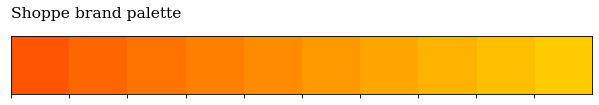

In [5]:
sns.palplot(['#FF5500','#FF6600','#FF7300','#FF8000','#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFCC00'])
plt.title("Shoppe brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [6]:
colors = ['#FF5500','#FF6600','#FF7300','#FF8000','#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFCC00']
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

## Tạo tên bảng và thanh Lọc

In [7]:
ten_bang = Layout(justify_content='center', 
               align_items='center',
               display='flex',
               #border= '2px solid orange',
               padding= '5px',
               margin= '0px',
               height='100%',
               width='100%')
wLabel = widgets.Label(value='Thành phố', layout=ten_bang)
wLabel.add_class('test_label')

Label(value='Thành phố', layout=Layout(align_items='center', display='flex', height='100%', justify_content='c…

In [8]:
ten_bang_box = HBox([wLabel],layout=Layout(justify_content= 'center'))

In [9]:
# Thanh chọn
list_khu_vuc = ['Cả nước', 'Miền Nam', 'Miền Trung', 'Miền Bắc',]
list_muc_tieu = ['Doanh số', 'Tồn kho', 'Doanh thu', 'Lượt thích', 'Lượt đánh giá']
list_sort = ["Cao nhất", "Thấp nhất"]

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='center',
)
W_heat_map = widgets.Checkbox(value=True, description='Hiển thị Heatmap')
W_khu_vuc = widgets.Dropdown(description='Khu vực :',
                             options = list_khu_vuc ,
                             value='Cả nước',
                             style = {'description_width': 'initial'},
                             layout = form_item_layout)                      
W_muc_tieu = widgets.Dropdown(description='Mục tiêu :',
                          options = list_muc_tieu,
                          style = {'description_width': 'initial'},
                          layout = form_item_layout)                     
W_sort = widgets.RadioButtons(description='Sắp xếp :',
                           options = list_sort,
                           style = {'description_width': 'initial'},
                           layout = Layout(flex_flow='columnt'), activecolor='orange')

In [10]:
# HTML(
#     value = "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box label{margin:5px !important;width: 82px !important;}</style>"
# )

HTML(value='<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box label{margin:5px !impo…

In [11]:
box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    #border='solid',
                    width='100%',
                    background_color= 'blue',
                    #border = '2px solid rgb(79, 185, 227)',
                    padding= '8px',
                    margin= '0px',
                    border_radius= '5px',
                    justify_content="center",
                    height='60px'
                   )
box_thanh_chon = HBox([W_heat_map, W_khu_vuc,W_muc_tieu, W_sort], layout = box_layout)

In [12]:
box_ten_bang_thanh_chon = VBox([ten_bang_box,box_thanh_chon])

## Tạo map

In [13]:
# Tạo dữ liệu
data_Map_1 = data_ID[['item_id','Tỉnh']]
data_Map_2 = data_DATA[["item_id",'Doanh số','Tồn kho','Doanh thu','Lượt thích','Lượt đánh giá']]
data_Map_3 = pd.merge(data_Map_1 , data_Map_2 ,on = "item_id")  
data_Map_4 = data_Map_3.groupby('Tỉnh').sum()
data_Map_5 = pd.merge(data_Map_4 ,data_LOC ,on = "Tỉnh")

# Load map geojson
import json
with open('vietnam.geojson',encoding="utf-8") as file:
    Viet_Nam = json.load(file)
# Đổi tên Thừa Thiên - Huế => Thừa Thiên Huế, Hồ Chí Minh city = TP. Hồ Chí Minh
def Doi_ten(text):
    text = text.replace("TP. Hồ Chí Minh","Hồ Chí Minh city")
    text = text.replace("Thừa Thiên Huế","Thừa Thiên - Huế")
    return text

# Vẽ Map
ca_nuoc = [15.854377, 106.029966, 5 , 4.5]
mien_nam = [10.303300, 105.985360, 7, 5.7]
mien_trung = [14.556769, 108.065010,7, 6]
mien_bac = [20.975158, 105.678033, 7, 5.1]

def Ve_map(Lists='Doanh số',  Loai_bieu_do = True, Loc= "Cả nước", ):
    if Loc == 'Cả nước':
        wLabel.value = f'DashBoard về {Lists.lower()} của sản phẩm điện thoại của Shoppe trên cả nước'
        x = ca_nuoc[0]
        y = ca_nuoc[1]
        z = ca_nuoc[2]
        t = ca_nuoc[3]
    elif Loc == "Miền Nam":
        x = mien_nam[0]
        y = mien_nam[1]
        z = mien_nam[2]
        t = mien_nam[3]
        wLabel.value = f'DashBoard về {Lists.lower()} của sản phẩm điện thoại của Shoppe khu vực Miền Nam'
    elif Loc == "Miền Trung":
        x = mien_trung[0]
        y = mien_trung[1]
        z = mien_trung[2]
        t = mien_trung[3]
        wLabel.value = f'DashBoard về {Lists.lower()} của sản phẩm điện thoại của Shoppe khu vực Miền Trung'
    else:
        x = mien_bac[0]
        y = mien_bac[1]
        z = mien_bac[2]
        t = mien_bac[3]
        wLabel.value = f'DashBoard về {Lists.lower()} của sản phẩm điện thoại của Shoppe khu vực Miền Bắc'
    output_map.clear_output()
    with output_map:
        if Loai_bieu_do == True:
            heatMap_data = list(zip(data_Map_5['latitude'], data_Map_5['longitude'], data_Map_5[Lists]))
            f_Figure = folium.Figure(width=286, height=570)
            fig_map    = folium.Map(location = (f'{x}', f'{y}'), 
                                  zoom_start= f'{z}',
                                 ).add_to(f_Figure)
            f_heatMap = HeatMap(data = heatMap_data,
                                 min_opacity=0.6,
                                 # max_val = 120,
                                 radius = 20,
                                 overlay = True
                                ).add_to(fig_map)
            display(fig_map)
        else:
            data_Map_6 = data_Map_5.copy()
            data_Map_6['Tỉnh mới'] = data_Map_5['Tỉnh'].apply(Doi_ten)
            
            fig_map = px.choropleth_mapbox(data_Map_6, geojson=Viet_Nam, color=Lists,
                                       locations="Tỉnh mới", featureidkey="properties.name",
                                       center={"lat": x,  "lon": y},
                                       mapbox_style="carto-positron", zoom=t,
                                       color_continuous_scale=colors[::-1],
                                       labels={'Tỉnh mới':'Tỉnh'},
                                       width=350, height=570,                              
                                          )
            fig_map.update_layout(coloraxis_colorbar=dict(
                title=f"<b>{Lists}</b>",
                title_font_color='#FF5500',
                title_font_size=14,
                title_font_family="Arial",
                thicknessmode="pixels", 
                thickness=10,
                lenmode="pixels",
                len=300,
                y=0.97,
                orientation="h",
                titleside = 'top',
            ))
            fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
            display(fig_map)

In [14]:
output_map = widgets.Output(layout=dict(#border='1px solid black',
                                        width='300px', height='580px',
                                        justify_content='center', 
                                        align_items='center',
                                        justify_self='center',
                                        align_content = 'center'))

In [15]:
#wInKetQua_heat_map = widgets.interactive(Ve_map, Lists=W_muc_tieu, Loai_bieu_do = W_heat_map, Loc= W_khu_vuc)

## Top 5

In [16]:
# Data_top_5
data_top_5_1 = data_DATA[["item_id",'shop_id',"brand",'Doanh số','Tồn kho','Doanh thu','Giá gốc', 'Khuyến mãi %', 'Giá khuyến mãi',
                          'Lượt thích','Lượt đánh giá','product_image_link']]
data_top_5_2 = pd.merge(data_ID[['item_id','Tỉnh']] , data_LOC[['Tỉnh','Khu Vực']],on = "Tỉnh")  
data_top_5_3 = pd.merge(data_top_5_1 , data_top_5_2,on = "item_id")  

### Top 5 sản phẩm và hình ảnh

In [17]:
output_top_5 = widgets.Output(layout=dict(width='350px', height='280px'))

Lay_out_top = Layout(width='195px', height='195px')
output_top_5_0 = widgets.Output(layout=Lay_out_top)
output_top_5_1 = widgets.Output(layout=Lay_out_top)
output_top_5_2 = widgets.Output(layout=Lay_out_top)
output_top_5_3 = widgets.Output(layout=Lay_out_top)
output_top_5_4 = widgets.Output(layout=Lay_out_top)

Lay_out_ten = Layout(width='195px', height='130px', justify_content='center', align_items='center',
                     justify_self='center',align_content = 'center')
output_ten_top_5_0 = widgets.Output(layout=Lay_out_ten)
output_ten_top_5_1 = widgets.Output(layout=Lay_out_ten)
output_ten_top_5_2 = widgets.Output(layout=Lay_out_ten)
output_ten_top_5_3 = widgets.Output(layout=Lay_out_ten)
output_ten_top_5_4 = widgets.Output(layout=Lay_out_ten)

Lay_out_data = Layout(width='195px', height='90px')
output_data_top_5_0 = widgets.Output(layout=Lay_out_data)
output_data_top_5_1 = widgets.Output(layout=Lay_out_data)
output_data_top_5_2 = widgets.Output(layout=Lay_out_data)
output_data_top_5_3 = widgets.Output(layout=Lay_out_data)
output_data_top_5_4 = widgets.Output(layout=Lay_out_data)

top_box_0 = VBox([output_ten_top_5_0,output_top_5_0,output_data_top_5_0])
top_box_1 = VBox([output_ten_top_5_1,output_top_5_1,output_data_top_5_1])
top_box_2 = VBox([output_ten_top_5_2,output_top_5_2,output_data_top_5_2])
top_box_3 = VBox([output_ten_top_5_3,output_top_5_3,output_data_top_5_3])
top_box_4 = VBox([output_ten_top_5_4,output_top_5_4,output_data_top_5_4])

box_top_5 = HBox([top_box_0,top_box_1,top_box_2,top_box_3,top_box_4])

In [18]:
# Tạo hàm sửa tên
def Sua_ten(text):
    x = text.split(' ')
    for i in range(4,len(x),4):
        x[i] = x[i]+"\n" 
    text = ' '.join(x) 
    return text

In [19]:
def Xu_lu_du_lieu_01(Lists='Doanh số', Sort = 'Cao nhất', Loc="Cả nước"):
    if Loc ==  "Cả nước":
        data = data_top_5_3.copy()
    else : 
        data = data_top_5_3[data_top_5_3['Khu Vực'] == Loc]
    
    if Sort == 'Cao nhất':
        data_top_5 = data[['item_id',Lists,'product_image_link']].nlargest(5,columns = Lists)
        data_thong_tin = data[['item_id',Lists,'Giá gốc', 'Khuyến mãi %', 'Giá khuyến mãi']].nlargest(5, columns = Lists)
    else:
        data_top_5 = data[['item_id',Lists,'product_image_link']].nsmallest(5, columns = Lists)
        data_thong_tin = data[['item_id',Lists,'Giá gốc', 'Khuyến mãi %', 'Giá khuyến mãi']].nsmallest(5, columns = Lists)
    
    top_5_name = pd.merge(data_top_5, data_ID[["item_id","Tên"]], on="item_id")
    top_5_name['Tên'] = top_5_name['Tên'].apply(Sua_ten)
    
    data_thong_tin_1 = data_thong_tin.reset_index()
    
    return top_5_name, data_thong_tin_1  

In [20]:
def Top_Hinh_anh_5(Lists='Doanh số', Sort = 'Cao nhất', Loc="Cả nước"):       
    data, data_thong_tin = Xu_lu_du_lieu_01(Lists, Sort, Loc)
    
    wLabel_ten_top_5_sp.value=f'Hình ảnh top 5 sản phẩm có {Lists.lower()} {Sort.lower()}'
    
    output_top_5.clear_output()
    with output_top_5:            
        fig = px.bar(data, x=['1','2','3','4','5'], y=Lists, 
                     width=335, height=260,
                     #color="Tỉnh",
                     #text = "Tỉnh"
                     color_discrete_sequence=colors[3:4],
                     labels={'x':'Top'},
                     #hover_name = "Tên"
                    )
        fig.update_layout(title=f"<b>Top 5 sản phẩm có {Lists.lower()} {Sort.lower()}</b>",
                          title_font_color='#FF5500',
                          title_font_size=14,
                          title_font_family="Arial",
                          xaxis_title="Top",
                          yaxis_title= Lists,
                          margin={"r":0,"t":25,"l":0,"b":0})
        fig.show()  
    def ve_sp(op = output_top_5, op_ten=output_ten_top_5_0, op_data=output_data_top_5_0, Top = 1):
        op.clear_output()
        with op:             
            fig = plt.figure(figsize=(6, 10))
            ax1 = fig.add_subplot(1,1,1)        
            urllib.request.urlretrieve(data['product_image_link'][Top],f"hinh{Top}.png")  
            img = Image.open(f"hinh{Top}.png")
            name = data['Tên'][Top].title()
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.spines['top'].set_visible(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.imshow(img)
            plt.tight_layout()
            plt.show()
        op_ten.clear_output()
        with op_ten: 
            htmlWidget_ten = widgets.HTML(value = f"<b>Top {Top+1}</b>: {name}")
            htmlWidget_ten.add_class('ten_Top')
            display(htmlWidget_ten)
        
        op_data.clear_output()
        with op_data: 
            htmlWidget_data = widgets.HTML(value = f'''
            Giá gốc: {data_thong_tin['Giá gốc'][Top]:0,} VNĐ<br>
            Khuyến mãi: {(data_thong_tin['Khuyến mãi %'][Top]*100):.0f} %<br>
            Giá khuyến mãi: {data_thong_tin['Giá khuyến mãi'][Top]:0,.0f} VNĐ''')
            htmlWidget_data.add_class('ten_Data')
            display(htmlWidget_data)
        
    ve_sp(output_top_5_0,output_ten_top_5_0,output_data_top_5_0,0)
    ve_sp(output_top_5_1,output_ten_top_5_1,output_data_top_5_1,1)
    ve_sp(output_top_5_2,output_ten_top_5_2,output_data_top_5_2,2)
    ve_sp(output_top_5_3,output_ten_top_5_3,output_data_top_5_3,3)
    ve_sp(output_top_5_4,output_ten_top_5_4,output_data_top_5_4,4)

In [21]:
#wInKetQua_top_5 = widgets.interactive(Top_Hinh_anh_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)

### Top 5 shop

In [22]:
def Top_shop_5(Lists='Doanh số', Sort = 'Cao nhất', Loc="Cả nước"):
    output_top_shop_5.clear_output()
    with output_top_shop_5:
        if Loc ==  "Cả nước":
            data = data_top_5_3.copy()
        else : 
            data = data_top_5_3[data_top_5_3['Khu Vực'] == Loc]
        if Sort == 'Cao nhất':
            data_shop = data[['shop_id',Lists]].groupby('shop_id').sum().nlargest(5, columns = Lists)
        else:
            data_shop = data[['shop_id',Lists]].groupby('shop_id').sum().nsmallest(5, columns = Lists)   

        data_shop_1 = data_shop.reset_index() 
        data_shop_2 = data_ID[["shop_id","Tỉnh"]].drop_duplicates()    
        data_shop_3 = pd.merge(data_shop_1, data_shop_2, how = 'left',on = "shop_id") 
        data_shop_4 = data_shop_3.astype({'shop_id':str})

        fig = px.bar(data_shop_4, x='shop_id', y=Lists, color="Tỉnh",width=380, height=280,
                    #text = "Tỉnh"
                    color_discrete_sequence=colors[::3],
                    )
        #fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        
        fig.update_layout(title=f"<b>Top 5 shop có {Lists.lower()} {Sort.lower()}</b>",
                          title_font_color='#FF5500',
                          title_font_size=14,
                          title_font_family="Arial",
                          xaxis_title="Shop ID",
                          yaxis_title= Lists,
                          #xaxis_tickangle=-45,
#                           legend=dict(
#                           x=0,
#                           y=1.0,
#                           bgcolor='rgba(255, 255, 255, 0)',
#                           bordercolor='rgba(255, 255, 255, 0)'),
                          margin={"r":0,"t":25,"l":0,"b":0}
                         )
        fig.update(layout_showlegend=False)
        fig.show()  

In [23]:
output_top_shop_5 = widgets.Output(layout=dict(#border='1px solid black',
                                    width='390px', height='300px', 
                                        justify_content='flex-start', 
                                        align_items='flex-start',
                                        justify_self='flex-start',
                                        align_content = 'flex-start',
                                              ))

In [24]:
#wInKetQua_top_shop_5 = widgets.interactive(Top_shop_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)

### Top 5 thương hiệu

In [25]:
def Top_brand_5(Lists='Doanh số', Sort = 'Cao nhất', Loc="Cả nước"):
    
    output_top_brand_5.clear_output()
    with output_top_brand_5:
        if Loc ==  "Cả nước":
            data = data_top_5_3.copy()
        else : 
            data = data_top_5_3[data_top_5_3['Khu Vực'] == Loc]
        if Sort == 'Cao nhất':
            data_brand = data[['brand',Lists]].groupby('brand').sum().nlargest(5, columns = Lists)
        else:
            data_brand = data[['brand',Lists]].groupby('brand').sum().nsmallest(5, columns = Lists)   

        data_brand_1 = data_brand.reset_index()

        fig = go.Figure(data=[go.Pie(labels=data_brand_1['brand'], values=data_brand_1[Lists], 
                                     hole=.3,
                                     textinfo='label+percent',
                                     insidetextorientation='radial',
                                     #hovertemplate = "%{label}: <br>Giá trị: %{value} <br>%{percent}"
                                    )])
        
        fig.update_layout(title=f"<b>Top 5 thương hiệu có {Lists.lower()} {Sort.lower()}</b>",
                          title_font_color='#FF5500',
                          title_font_size=14,
                          title_font_family="Arial",
                          width=330, height=250,
                          margin={"r":0,"t":25,"l":0,"b":0}
                         )
        fig.update_traces(hoverinfo='label+percent+value', #textfont_size=20,                          
                          marker=dict(colors=colors[::2]))
        
        fig.update(layout_showlegend=False)
        fig.show()  

In [26]:
output_top_brand_5 = widgets.Output(layout=dict(#border='1px solid black',
                                    width='350px', height='280px', 
                                        justify_content='flex-start', 
                                        align_items='flex-start',
                                        justify_self='flex-start',
                                        align_content = 'flex-start',
                                               ))


In [27]:
#wInKetQua_top_brand = widgets.interactive(Top_brand_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)

### WC

In [28]:
data_cmt = data_RATING.copy()
data_cmt.dropna(inplace=True, axis=0, how="any")
data_cmt_1 = data_cmt.reset_index()

In [29]:
ten_WC = Layout(justify_content='center', 
               align_items='center',
               display='flex',
               padding= '5px',
               margin= '0px',
               height='30px',
               width='290px')
wLabel_WC = widgets.Label(value='Wordcloud về bình luận', layout=ten_WC)
wLabel_WC.add_class('ten_WC')

Label(value='Wordcloud về bình luận', layout=Layout(align_items='center', display='flex', height='30px', justi…

In [30]:
def Ve_WC(Sort = 'Cao nhất'):    
    if Sort == 'Cao nhất':
        wLabel_WC.value = 'Wordcloud bình luận đánh giá 4,5 sao'
    else:
        wLabel_WC.value = 'Wordcloud bình luận đánh giá 1,2,3 sao'
        
    output_top_WC.clear_output()
    with output_top_WC: 
        if Sort == 'Cao nhất':
            text_cmt = " ".join(review for review in data_cmt_1[data_cmt_1["Rank"]==Sort]['VAN'])
            mask_img = np.array(Image.open("like1.jpg"))
        else:
            text_cmt = " ".join(review for review in data_cmt_1[data_cmt_1["Rank"]==Sort]['VAN'])
            mask_img = np.array(Image.open("dislike1.jpg"))

        stopwords_1 = set(STOPWORDS)
        stopwords_1.update(["shop", "máy","hàng","nan",'mua','giao',"ko",'có',"dùng","nha","đc","còn","sau","ạ",'là',"bị","hẹn","lưng","màn","em",
                   "sản_phẩm", "chất_lượng","điện_thoại","ngày","nhiều","thứ","biết",'chạy','bán','thêm','qua','nói',"về",'gần','độ',
                   'khi','đặt', 'tầm','sáng','lần','mạng','hơn','bên','hơi','đt','phải',"xem",'gọi',"Sản_phẩm",'khác','sp','chụp','sài',
                   "người",'lên',"nghe",'mang',"thấy","hết","quảng_cáo","nhận",'làm',"xu","nhìn","nguyên",'gửi',"thời_gian","tặng",''
                   "sao","chơi",'ảnh',"hãng",'tay','mô_tả','đánh_giá','Tính_năng',"hình","chúc", 'cầm',"hiện_tại",'xài','tiếp',"kèm"
                    'đồng_tiền','dán','dc','sử_dụng','nhé','may','bạn','hộp',"bảo",'ra','đi','mong','cục','mặt','nhắn','lúc','chủ',"hôm",
                    'vào','thôi','hỏi','khách','tin',"nt",'tính_chất','đồng_tiền',"ngoài",'trong','xong','giống','điểm','mn','kêu',
                    'cho','ít','web',"đen",'xanh','vàng','anh_em','người_thân','cơ_bản','tiếng','điện','thay','kiểu','dt','con','muốn',
                    'cái','đâu','vô','báo','trước','được','đầu','thèm','cắm','số','mở','nên','chỗ','trắng','số','sóng','lắp','đầy',"v",
                    'j','chỗ','bắt','kèm','bấm','lấy','giờ','chắc','cần','hồng','tuần','coi','chân','góc','chịu','nắp','mau','ăn','ae'
                   ])
        wordcloud = WordCloud(background_color="#FFFFFF", max_words=100, 
                              mask=mask_img,
                              width=3000,
                              height=2000,
                              random_state=1,
                              colormap=cmap1,
                              collocations=False,
                              stopwords=stopwords_1
                              ).generate(text_cmt)
        plt.figure(figsize=(10,10))
        plt.tight_layout(pad=0)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [31]:
output_top_WC = widgets.Output(layout=dict(#border='1px solid black',
                                    width='290px', height='270px'))

In [32]:
#wInKetQua_top_WC = widgets.interactive(Ve_WC, Sort = W_sort)

In [33]:
box_test_WC = widgets.VBox([wLabel_WC, output_top_WC])

In [34]:
ten_top_5_sp = Layout(
               justify_content='center', 
               align_items='center',
               display='flex',
               padding= '5px',
               margin= '0px',
               height='30px',
               width='100%')
wLabel_ten_top_5_sp = widgets.Label(value='Hình ảnh top 5 sản phẩm', layout=ten_top_5_sp)
wLabel_ten_top_5_sp.add_class('ten_WC')

Label(value='Hình ảnh top 5 sản phẩm', layout=Layout(align_items='center', display='flex', height='30px', just…


# Dash Board

In [35]:
wInKetQua_map = widgets.interactive(Ve_map, Lists=W_muc_tieu, Loai_bieu_do = W_heat_map, Loc= W_khu_vuc)
wInKetQua_top_5 = widgets.interactive(Top_Hinh_anh_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)
wInKetQua_top_shop_5 = widgets.interactive(Top_shop_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)
wInKetQua_top_brand = widgets.interactive(Top_brand_5, Lists=W_muc_tieu, Sort = W_sort, Loc=W_khu_vuc)
wInKetQua_top_WC = widgets.interactive(Ve_WC, Sort = W_sort)

In [36]:
box1 = HBox([output_top_5, output_top_brand_5])
box2 = HBox([output_top_shop_5, box_test_WC])
box3 = HBox([output_map,VBox([box2, box1])])
box4 = VBox([box_ten_bang_thanh_chon, box3])
box5 = VBox([wLabel_ten_top_5_sp,box_top_5])
box6 = VBox([box4,box5])

box3.add_class('box_chung')
ten_bang_box.add_class('box_style')
output_map.add_class('box_map')
box_thanh_chon.add_class('box_bang_chon')
output_top_5.add_class('box_sp')
output_top_shop_5.add_class('box_shop')
output_top_brand_5.add_class('box_brand')
box_test_WC.add_class('box_WC')
box5.add_class('box_top')
display(box6)

In [37]:
%%html
<style>
.ten_WC{
    color:#FF5500;
    font-size:14px;
    font-weight: bold;
}
.test_label{
    color:White;
    font-size:150%;
}
.box_style{
    width:100%;
    border : 5px solid #FF5500;
    height: auto;
    background-color:#FF6600;  
    text-align:center;
    border-radius: 50px 20px;    
}
.box_bang_chon{
    width:100%;
    border : 2px solid #FFBF00;
    height: auto;
    background-color:white;  
    text-align:center;
    border-radius: 20px;
}
.box_map{
    width:100%;
    border : 1px solid #FFBF00;
    height: auto; 
    text-align:center;
    #border-radius: 15px;
}
.box_shop{
    width:100%;
    #border : 1px solid #FFBF00;
    #border-radius: 20px 20px 0px 20px;     
}
.box_WC{
    width: 300px;
    #border : 1px solid #FFBF00;
    #border-radius: 20px;     
}
.box_sp{
    width:100%;
    #border : 1px solid #FFBF00;
    #border-radius: 20px;     
}
.box_brand{
    width:100%;
    #border : 1px solid #FFBF00;
    #border-radius: 20px;     
}
.box_top{
    width:100%;
    border : 2px solid #FFBF00;
    border-radius: 20px;     
}
.box_chung{
    width:100%;
    border : 2px solid #FFBF00;
    border-radius: 20px;     
}
.ten_Top{
    color:#FF7300;
    font-size:13px;
    font-weight: bold;
    word-wrap: normal;
    text-align: center;
    word-spacing: -2px;
    justify_content:center ;
    align_items:center;
    justify_self:center;
    align_content:center;
}
.ten_Data{
    color:#FF5500;
    font-size:12px;
    #font-weight: bold;
    word-wrap: normal;
    text-align: center;
}
</style>